In [1]:
#show the dataset
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['cuny-data-challenge-2019', 'dohmh-inpsect', 'mydata', 'yelp-star', 'inspected-data']


In [2]:
print(os.listdir("../input"))

['cuny-data-challenge-2019', 'dohmh-inpsect', 'mydata', 'yelp-star', 'inspected-data']


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import pandas as pd
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import datetime as dt
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter
import re


<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
</ul>

# Part1:Data Exploration


## Part 1.1: Understand the dataset

In [4]:
#upload the inspections data
df = pd.read_csv('../input/cuny-data-challenge-2019/inspections_train.csv', parse_dates=['inspection_date'])

# upload the venue data
venue_stats = pd.read_csv('../input/cuny-data-challenge-2019/venues.csv').set_index('camis')

# upload the violations data
violations = pd.read_csv('../input/cuny-data-challenge-2019/violations.csv', parse_dates=['inspection_date'])

In [5]:
inspect = pd.read_csv('../input/dohmh-inpsect/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
inspect.head()

,CAMIS,DBA,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION CODE,SCORE,GRADE
0,41308050,RELISH CONCESSIONS (LASKER RINK),NaN,American,1/5/2015,15L,NaN,NaN
1,41308050,RELISH CONCESSIONS (LASKER RINK),NaN,American,1/5/2015,02B,7.0,A
2,50003303,BROOKLYN SWEET SPOT,11205.0,Bakery,2/11/2015,20F,NaN,NaN
3,50003303,BROOKLYN SWEET SPOT,11205.0,Bakery,2/11/2015,10F,2.0,A
4,40882360,NEW YORK UNIVERSITY - PALLADIUM FOOD COURT,10003.0,American,3/30/2015,06E,11.0,A


In [6]:
#show number of rows and columns of the inspections_train dataset
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

Num of rows: 92528
Num of columns: 5


In [7]:
#show the name of entities
df.columns

Index(['id', 'camis', 'inspection_date', 'inspection_type', 'passed'], dtype='object')

## Part 1.2: Data cleaning

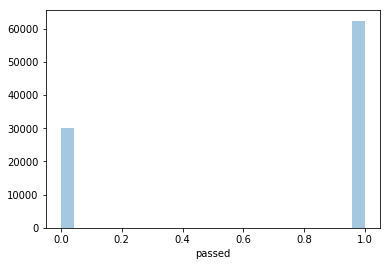

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(df['passed'], kde=False)

### Drop the nulls in violations df
work on the violation data, we find out that when the inspection_date is 1900-01-01, all the other data are null excepting camis. So we drop these columns because they make no sense.

In [9]:
violations_check = violations[violations.inspection_date == '1900-01-01']
violations_check.head()
# so later we can drop rows with inspection_date == 1900-01-01

,camis,inspection_date,inspection_type,action,violation_description
249,50087107,1900-01-01,NaN,NaN,NaN
527,50084801,1900-01-01,NaN,NaN,NaN
893,50090400,1900-01-01,NaN,NaN,NaN
997,50072304,1900-01-01,NaN,NaN,NaN
1133,50087807,1900-01-01,NaN,NaN,NaN


In [10]:
df[df.inspection_date < '2015-01-01'].count()
#so later we could remove inspection date earlier than 2015-01-01

id                 49
camis              49
inspection_date    49
inspection_type    49
passed             49
dtype: int64

# Part 2:Feature Preprocessing

In [11]:
violations = violations.drop(['inspection_type'], axis=1)

In [12]:
# create the violation count feature
# count feature is number of violations
# before that we need remove actions = No violations were recorded at the time of this inspection.
violation_df1 = violations[violations.action != 'No violations were recorded at the time of this inspection.']
violation_counts = violation_df1.groupby(['camis', 'inspection_date']).size()
violation_counts = violation_counts.reset_index().set_index(['camis', 'inspection_date'])
violation_counts.columns = ['n_violations']
violation_counts.head()

n_violations
camis    inspection_date              
30075445 2016-02-18                  2
         2017-05-18                  2
         2018-05-11                  2
30112340 2016-04-30                  6
         2016-10-03                  5

In [13]:
df = df.merge(violation_counts, 'left', left_on = ['camis', 'inspection_date'], right_index = True)

In [14]:
violation_df = violations[violations.action != 'No violations were recorded at the time of this inspection.']

In [15]:
viol_desc = violation_df.violation_description
viol_str = viol_desc.str.cat(sep = ' ')

In [16]:
stop = set(stopwords.words('english'))
list_of_words = [i.lower() for i in wordpunct_tokenize(viol_str) if i.lower() not in stop and i.isalpha()]
list_of_words[:15]

['food',
 'contact',
 'surface',
 'properly',
 'maintained',
 'facility',
 'vermin',
 'proof',
 'harborage',
 'conditions',
 'conducive',
 'attracting',
 'vermin',
 'premises',
 'allowing']

In [17]:
wordfreqdist = nltk.FreqDist(list_of_words)
mostcommon = wordfreqdist.most_common(30)
print(mostcommon)

[('food', 431689), ('flies', 235116), ('non', 167404), ('properly', 155281), ('contact', 145358), ('surface', 141019), ('vermin', 124389), ('improperly', 122256), ('facility', 111464), ('equipment', 90222), ('maintained', 86565), ('used', 80168), ('sewage', 62282), ('f', 61686), ('areas', 61480), ('present', 59471), ('mice', 57260), ('constructed', 55178), ('unacceptable', 54620), ('material', 54620), ('sealed', 54156), ('raised', 54156), ('spaced', 54156), ('movable', 54156), ('allow', 54156), ('accessibility', 54156), ('cleaning', 54156), ('sides', 54156), ('underneath', 54156), ('unit', 54156)]


In [18]:
common_word = [item[0] for item in mostcommon]
common_word

['food',
 'flies',
 'non',
 'properly',
 'contact',
 'surface',
 'vermin',
 'improperly',
 'facility',
 'equipment',
 'maintained',
 'used',
 'sewage',
 'f',
 'areas',
 'present',
 'mice',
 'constructed',
 'unacceptable',
 'material',
 'sealed',
 'raised',
 'spaced',
 'movable',
 'allow',
 'accessibility',
 'cleaning',
 'sides',
 'underneath',
 'unit']

In [19]:
def word_count(row):
    row = re.sub('[^A-Za-z0-9]+', ' ', str(row))
    row = row.lower()
    word_count = 0
    for i in row.split():
        if i in common_word: 
             word_count  += 1
    return word_count 

In [20]:
violations['count'] = violations['violation_description'].apply(word_count)

In [21]:
violations.head()

,camis,inspection_date,action,violation_description,count
0,41721917,2019-01-03,Violations were cited in the following area(s).,Food contact surface not properly maintained.,5
1,41625337,2018-06-09,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,4
2,41706074,2018-10-29,Violations were cited in the following area(s).,Personal cleanliness inadequate. Outer garment...,1
3,41294017,2017-02-23,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,27
4,40999287,2017-10-11,Violations were cited in the following area(s).,Plumbing not properly installed or maintained;...,6


In [22]:
violation_counts1 = violations.groupby(['camis', 'inspection_date'])['count'].sum().reset_index()
violation_counts1.head()

,camis,inspection_date,count
0,30075445,2016-02-18,12
1,30075445,2017-05-18,31
2,30075445,2018-05-11,29
3,30112340,2016-04-12,0
4,30112340,2016-04-30,12


In [23]:
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0


In [24]:
df = df.merge(violation_counts1, 'left', on=['camis', 'inspection_date'])
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12


In [25]:
# add the inspect / re-inspect feature to our main data
df['re_inspect'] = df.inspection_type.str.contains('re-', regex=False, case=False).map(int)
df['initial_inspect'] = df.inspection_type.str.contains('initial', regex=False, case=False).map(int)
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0


In [26]:
# merge the venue stats with the inspection data
df = df.merge(venue_stats, 'left', left_on='camis', right_index=True)
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers


In [27]:
cuision_pass = df.groupby(['cuisine_description']).mean()[['passed']]
cuision_pass.columns = ['cuision_pass']
cuision_pass = cuision_pass.sort_values(by=['cuision_pass'], ascending=False)
cuision_pass.head()

,cuision_pass
cuisine_description,
Basque,1.000000
Nuts/Confectionary,1.000000
Czech,0.888889
Donuts,0.840206
Hotdogs,0.835294


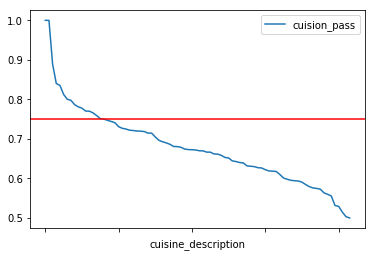

In [28]:
cuision_pass.plot()
plt.axhline(y=0.75, color='r', linestyle='-')

In [29]:
cutoff_value = 0.75
cuision_pass['cuision_pass'] = (cuision_pass.cuision_pass >= cutoff_value).map(int)

In [30]:
cuision_pass.head()

,cuision_pass
cuisine_description,
Basque,1
Nuts/Confectionary,1
Czech,1
Donuts,1
Hotdogs,1


In [31]:
# merge the cuision_pass with the inspection data
df = df.merge(cuision_pass, 'left', left_on='cuisine_description', right_index=True)
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1


In [32]:
# add the inspection month
df['inspection_month'] = df.inspection_date.dt.month
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,2
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4


In [33]:
inspect_month = df[['inspection_month', 'passed']].copy()
inspect_month.head(5)

,inspection_month,passed
0,2,1
1,5,1
2,5,1
3,4,1
4,4,1


In [34]:
month_scores = inspect_month.groupby('inspection_month').mean()[['passed']]

month_scores.columns = ['month_score']



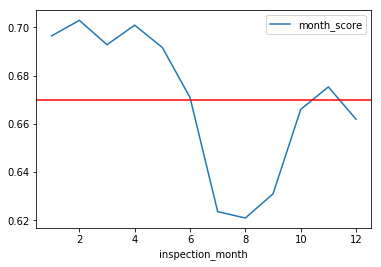

In [35]:
month_scores.plot()
plt.axhline(y=0.67, color='r', linestyle='-')

In [36]:
cutoff_value = 0.67
month_scores['month_cutoff'] = (month_scores.month_score >= cutoff_value).map(int)

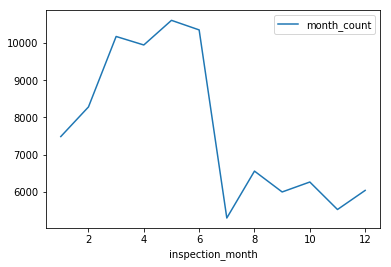

In [37]:
month_count = inspect_month.groupby('inspection_month').count()

month_count.columns = ['month_count']

month_count.plot()


In [38]:
#something wrong with merge for now. but we dont really want to merge to this df, we want to merge 
#month_scores to the df in predicted_A_version1
df = df.merge(month_scores, 'left', left_on='inspection_month', right_index=True)
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month,month_score,month_cutoff
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,2,0.702885,1
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1


In [39]:
#drop time before 2015-01-01
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df = df[~(df['inspection_date'] < '2015-01-01')]
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month,month_score,month_cutoff
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,2,0.702885,1
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1


In [40]:
#upload zillow data
zillow = pd.read_csv('../input/mydata/Sale_Prices_Zip.csv').set_index('zipcode')
zillow.head()

,mean_price
zipcode,
10025,981733
60657,367650
10023,1018942
77494,332250
60614,441767


In [41]:
# add the zillow house price to the main data set
# merge the venue stats with the inspection data
df = df.merge(zillow, 'left', left_on='zipcode', right_index=True)
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month,month_score,month_cutoff,mean_price
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,2,0.702885,1,NaN
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1,NaN
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,MORRIS PARK BAKE SHOP,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1,NaN
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1,NaN
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1,NaN


In [42]:
#fill na with mean price
df['mean_price'] = df.mean_price.fillna(df.mean_price.mean())

In [43]:
df['dba'] = df['dba'].str.lower()
df.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month,month_score,month_cutoff,mean_price
0,05d3b4d20d9b13f735ed405e298173d03993e5b9,30075445,2016-02-18,Cycle Inspection / Initial Inspection,1,2.0,12,0,1,morris park bake shop,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,2,0.702885,1,1.149613e+06
1,f7bbc29d10f35a7cf8d22116d56c1219633d4ba8,30075445,2017-05-18,Cycle Inspection / Initial Inspection,1,2.0,31,0,1,morris park bake shop,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1,1.149613e+06
2,953d197e60747b4617381489cfa2f0477a9b120b,30075445,2018-05-11,Cycle Inspection / Initial Inspection,1,2.0,29,0,1,morris park bake shop,BRONX,MORRIS PARK AVE,10462.0,Bakery,0,5,0.691627,1,1.149613e+06
3,a5c76e093d7599f9c0f343c46967944fa753e611,30112340,2016-04-12,Cycle Inspection / Initial Inspection,1,NaN,0,0,1,wendy's,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1,1.149613e+06
4,90212de5cb7426fb11768d935b6e914c595e0c3f,30112340,2016-04-30,Cycle Inspection / Re-inspection,1,6.0,12,1,0,wendy's,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,4,0.700894,1,1.149613e+06


In [44]:
df.shape

(92479, 19)

In [45]:
#yelp = pd.read_csv('../input/yelp-star/yelp.csv')
#yelp.head()

In [46]:
#yelp.columns = ['borough','dba', 'review_count', 'rating', 'zipcode' ]
#yelp['dba'] = yelp['dba'].str.lower()
#yelp.set_index(['dba','zipcode'])
#yelp.head()

In [47]:
#df = pd.merge(df, yelp, on=(['dba','zipcode']), how='left')

In [48]:
#df.shape

In [49]:
df.isna().sum()

id                        0
camis                     0
inspection_date           0
inspection_type           0
passed                    0
n_violations            828
count                     0
re_inspect                0
initial_inspect           0
dba                       0
boro                      0
street                    0
zipcode                1553
cuisine_description       0
cuision_pass              0
inspection_month          0
month_score               0
month_cutoff              0
mean_price                0
dtype: int64

In [50]:
#df = df.dropna()  

In [51]:
df = df.fillna(0)
df.isna().sum()

id                     0
camis                  0
inspection_date        0
inspection_type        0
passed                 0
n_violations           0
count                  0
re_inspect             0
initial_inspect        0
dba                    0
boro                   0
street                 0
zipcode                0
cuisine_description    0
cuision_pass           0
inspection_month       0
month_score            0
month_cutoff           0
mean_price             0
dtype: int64

In [52]:
df['count'] = df['count'].astype('int64', inplace = True, errors='ignore')
df['n_violations'] = df.n_violations.astype('int64', inplace = True, errors='ignore')
df['mean_price'] = df['mean_price'].round().astype('int64', inplace = True, errors='ignore')
#df['review_count'] = df['review_count'].astype('int64', inplace = True, errors='ignore')

# Part 3: Model Training and Result Evaluation
## Part 3.1: Split the dataset

In [53]:
from sklearn import model_selection
x_train, x_test= model_selection.train_test_split(df, test_size=0.2)

print('training data has %d observation with %d features'% x_train.shape)
print('test data has %d observation with %d features'% x_test.shape)

training data has 73983 observation with 19 features
test data has 18496 observation with 19 features


In [54]:
x_train.head()

,id,camis,inspection_date,inspection_type,passed,n_violations,count,re_inspect,initial_inspect,dba,boro,street,zipcode,cuisine_description,cuision_pass,inspection_month,month_score,month_cutoff,mean_price
54324,24d037730c7f8b6928e1546f2de7d00be4364032,50005442,2017-07-13,Cycle Inspection / Initial Inspection,1,1,3,0,1,griddle cafe deli,QUEENS,HUNTERS POINT AVE,11101.0,American,0,7,0.623629,0,1149613
81509,683af1cb434b2d959c1352f49e9ffc17cae39ba8,50056031,2016-10-03,Pre-permit (Non-operational) / Initial Inspection,1,2,33,1,1,word up cafe,BROOKLYN,PENNSYLVANIA AVE,11207.0,CafÃ©/Coffee/Tea,1,10,0.665974,0,1149613
9042,66a961122af268db77036e03a472fbf1b42367c6,40738920,2016-05-21,Cycle Inspection / Initial Inspection,0,5,15,0,1,george keeley,MANHATTAN,AMSTERDAM AVENUE,10024.0,American,0,5,0.691627,1,1149613
40878,3d7618c4028a7c88f31c571023291069a89bd6c1,41636588,2017-11-22,Cycle Inspection / Re-inspection,1,2,31,1,0,dunkin' donuts,BRONX,EAST GUNHILL ROAD,10467.0,CafÃ©/Coffee/Tea,1,11,0.675303,1,1149613
60752,daa33a4ac88a7bd634806cc790882d4a1fffa3cb,50015746,2018-04-12,Cycle Inspection / Re-inspection,0,4,14,1,0,punto cibaeno restaurant,QUEENS,89TH AVE,11432.0,Spanish,0,4,0.700894,1,1149613


## Part 3.2: Model Training and Selection

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression



classifier_RF = RandomForestClassifier()

In [56]:
# for filter method
from sklearn.feature_selection import f_classif, SelectKBest

# for wrapper method
from sklearn.feature_selection import RFECV

# for embedded method
from sklearn.feature_selection import SelectFromModel

numeric_features = ['n_violations', 'mean_price','count']
categorical_features = [ 're_inspect', 'initial_inspect', 'month_cutoff','cuision_pass']

In [57]:
# set up the model
target = ['passed']
mod = LogisticRegression(solver='saga', penalty='l1', C = 10, max_iter=150)

# set up the selector
selector = RFECV(mod, cv=5, scoring='neg_log_loss')

# we're going to get a convergence warning, so we'll filter those out here
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # fit the selector
    selector.fit(x_train[numeric_features + categorical_features], x_train[target].values.ravel())

# convert the scores into a dataframe object
feature_scores = pd.DataFrame({'features': numeric_features + categorical_features,
                               'scores': selector.grid_scores_*-1})
feature_scores.sort_values('scores')

,features,scores
1,mean_price,0.334777
0,n_violations,0.350734
6,cuision_pass,0.633940
5,month_cutoff,0.633940
4,initial_inspect,0.633940
3,re_inspect,0.633940
2,count,0.633940


In [58]:
mod = RandomForestClassifier(n_estimators=25, max_depth=10, min_samples_leaf=15)

mod.fit(x_train[numeric_features + categorical_features], x_train[target].values.ravel())

feature_scores = pd.DataFrame({'features': numeric_features + categorical_features,
                               'scores': mod.feature_importances_})
feature_scores.sort_values('scores', ascending=False)

,features,scores
0,n_violations,0.779049
2,count,0.173478
4,initial_inspect,0.027206
6,cuision_pass,0.007276
3,re_inspect,0.005964
1,mean_price,0.004094
5,month_cutoff,0.002932


In [59]:
#model_features = ['n_violations', 'count', 'review_count',   'initial_inspect','re_inspect', 'cuision_pass', 'rating', 'mean_price']
#model_features = [ 'n_violations', 'count', 'initial_inspect', 'cuision_pass','re_inspect', 'mean_price','month_cutoff' ]
model_features = [ 'n_violations', 'count', 'initial_inspect']

In [60]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [61]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'max_depth': [8, 10,12]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(x_train[model_features], x_train.passed)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [62]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.873
Best parameters set:
	max_depth: 8


In [63]:
# change these parameters!
parameters = {
    'n_estimators': 25,
    'max_depth': 10,
    'min_samples_leaf': 15
}

# we use the ** operator to expand the parameters dictionary
clf_custom = RandomForestClassifier(**parameters)
clf_custom.fit(x_train[model_features], x_train.passed)
test_solution_cusotm = clf_custom.predict_proba(x_test[model_features])
loss3_custom = log_loss(x_test.passed.values, test_solution_cusotm)
print(f'log loss: {loss3_custom:.3f}')

log loss: 0.298


In [64]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
clf.fit(x_train[model_features], x_train.passed) 
test_solution_cusotm1 = clf.predict_proba(x_test[model_features])
loss3_custom = log_loss(x_test.passed.values, test_solution_cusotm1)
print(f'log loss: {loss3_custom:.3f}')

log loss: 0.365


In [65]:
#logistic regression
classifier_logistic = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', C = 5)
classifier_logistic.fit(x_train[model_features], x_train.passed)
test_solution_cusotm2 = classifier_logistic.predict_proba(x_test[model_features])
loss3_custom = log_loss(x_test.passed.values, test_solution_cusotm2)
print(f'log loss: {loss3_custom:.3f}')

log loss: 0.339


In [66]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(x_train[model_features], x_train.passed)
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Best score: 0.854
Best parameters set:
	C: 1
	penalty: 'l1'


In [67]:
#KNN
classifier_KNN = KNeighborsClassifier(n_neighbors=10)
classifier_KNN.fit(x_train[model_features], x_train.passed)
test_solution_cusotm3 = classifier_KNN.predict_proba(x_test[model_features])
loss3_custom = log_loss(x_test.passed.values, test_solution_cusotm3)
print(f'log loss: {loss3_custom:.3f}')


log loss: 0.776


In [68]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(classifier_KNN,parameters, cv=5)
Grid_KNN.fit(x_train[model_features], x_train.passed)
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.863
Best parameters set:
	n_neighbors: 10


In [69]:
from sklearn.linear_model import Ridge
import numpy as np
ridge = Ridge()
ridge.fit(x_train[model_features], x_train.passed)
test_solution_cusotm4 = ridge.predict(x_test[model_features])
loss3_custom = log_loss(x_test.passed.values, test_solution_cusotm4)
print(f'log loss: {loss3_custom:.3f}')


log loss: 0.415


# Upload test data and build model

In [70]:
# load the test data and add the `n_violations` feature
test_data = pd.read_csv('../input/cuny-data-challenge-2019/inspections_test.csv', parse_dates=['inspection_date'])
test_data.head()

,id,camis,inspection_date,inspection_type
0,1e739c8bfcd2019de709ab292a63b52c1c63f050,30112340,2019-03-04,Cycle Inspection / Initial Inspection
1,3902bc2b2b972640a7e6ae7aa45abf93bf1bc6bc,40356018,2018-10-30,Cycle Inspection / Initial Inspection
2,d89cf9ae6c2825ca9d546037245a244efe02ebb2,40356151,2018-10-06,Cycle Inspection / Initial Inspection
3,98ffb30b54e9dbd7772a39a7ca69aaa751d1871e,40359480,2018-09-28,Cycle Inspection / Initial Inspection
4,acaf6d44b61538c6ec8df101b4faebe0ebaf41ac,40359705,2019-04-06,Cycle Inspection / Initial Inspection


In [71]:
# add the inspect / re-inspect feature to our main data
test_data['re_inspect'] = test_data.inspection_type.str.contains('re-', regex=False, case=False).map(int)
test_data['initial_inspect'] = test_data.inspection_type.str.contains('initial', regex=False, case=False).map(int)
test_data.head()

,id,camis,inspection_date,inspection_type,re_inspect,initial_inspect
0,1e739c8bfcd2019de709ab292a63b52c1c63f050,30112340,2019-03-04,Cycle Inspection / Initial Inspection,0,1
1,3902bc2b2b972640a7e6ae7aa45abf93bf1bc6bc,40356018,2018-10-30,Cycle Inspection / Initial Inspection,0,1
2,d89cf9ae6c2825ca9d546037245a244efe02ebb2,40356151,2018-10-06,Cycle Inspection / Initial Inspection,0,1
3,98ffb30b54e9dbd7772a39a7ca69aaa751d1871e,40359480,2018-09-28,Cycle Inspection / Initial Inspection,0,1
4,acaf6d44b61538c6ec8df101b4faebe0ebaf41ac,40359705,2019-04-06,Cycle Inspection / Initial Inspection,0,1


In [72]:
# add the violation counts to the main data set
test_data = test_data.merge(violation_counts, 'left', left_on=['camis', 'inspection_date'], 
                            right_index=True)

In [73]:
# add the inspection month
test_data['inspection_month'] = (test_data.inspection_date.dt.strftime('%m').map(int) + 6) % 12

In [74]:
test_data = test_data.merge(month_scores, 'left', left_on='inspection_month', right_index=True)

In [75]:
test_data = test_data.merge(violation_counts1, 'left', on=['camis', 'inspection_date'])


In [76]:
# merge the venue stats with the inspection data
test_data = test_data.merge(venue_stats, 'left', left_on='camis', right_index=True)


In [77]:
# merge the cuision_pass with the inspection data
test_data = test_data.merge(cuision_pass, 'left', left_on='cuisine_description', right_index=True)


In [78]:
# merge the venue stats with the inspection data
test_data = test_data.merge(zillow, 'left', left_on='zipcode', right_index=True)


In [79]:
#fill na with mean price
test_data['mean_price'] = test_data.mean_price.fillna(test_data.mean_price.mean())

In [80]:
test_data = test_data.fillna(0)
test_data.isna().sum()

id                     0
camis                  0
inspection_date        0
inspection_type        0
re_inspect             0
initial_inspect        0
n_violations           0
inspection_month       0
month_score            0
month_cutoff           0
count                  0
dba                    0
boro                   0
street                 0
zipcode                0
cuisine_description    0
cuision_pass           0
mean_price             0
dtype: int64

In [81]:
test_data['count'] = test_data['count'].astype('int64', inplace = True, errors='ignore')
test_data['n_violations'] = test_data.n_violations.astype('int64', inplace = True, errors='ignore')
test_data['mean_price'] = test_data['mean_price'].round().astype('int64', inplace = True, errors='ignore')

In [82]:
test_data.head()

,id,camis,inspection_date,inspection_type,re_inspect,initial_inspect,n_violations,inspection_month,month_score,month_cutoff,count,dba,boro,street,zipcode,cuisine_description,cuision_pass,mean_price
0,1e739c8bfcd2019de709ab292a63b52c1c63f050,30112340,2019-03-04,Cycle Inspection / Initial Inspection,0,1,3,9,0.631008,0,36,WENDY'S,BROOKLYN,FLATBUSH AVENUE,11225.0,Hamburgers,1,1160117
1,3902bc2b2b972640a7e6ae7aa45abf93bf1bc6bc,40356018,2018-10-30,Cycle Inspection / Initial Inspection,0,1,2,4,0.700894,1,31,RIVIERA CATERERS,BROOKLYN,STILLWELL AVENUE,11224.0,American,0,420142
2,d89cf9ae6c2825ca9d546037245a244efe02ebb2,40356151,2018-10-06,Cycle Inspection / Initial Inspection,0,1,3,4,0.700894,1,27,BRUNOS ON THE BOULEVARD,QUEENS,ASTORIA BOULEVARD,11369.0,American,0,1160117
3,98ffb30b54e9dbd7772a39a7ca69aaa751d1871e,40359480,2018-09-28,Cycle Inspection / Initial Inspection,0,1,2,3,0.692791,1,31,1 EAST 66TH STREET KITCHEN,MANHATTAN,EAST 66 STREET,10065.0,American,0,1160117
4,acaf6d44b61538c6ec8df101b4faebe0ebaf41ac,40359705,2019-04-06,Cycle Inspection / Initial Inspection,0,1,3,10,0.665974,0,33,NATHAN'S FAMOUS,BROOKLYN,SURF AVENUE,11224.0,Hotdogs,1,420142


In [83]:
# create a `Predicted` column
# for this example, we're using the model we previously trained
test_data['Predicted'] = [_[1] for _ in clf_custom.predict_proba(test_data[model_features])]

# take just the `id` and `n_violations` columns (since that's all we need)
submission = test_data[['id', 'Predicted']].copy()

# IMPORTANT: Kaggle expects you to name the columns `Id` and `Predicted`, so let's make sure here
submission.columns = ['Id', 'Predicted']

# write the submission to a csv file so that we can submit it after running the kernel
submission.to_csv('submission3.csv', index=False)

# let's take a look at our submission to make sure it's what we want
submission.head()

,Id,Predicted
0,1e739c8bfcd2019de709ab292a63b52c1c63f050,0.879662
1,3902bc2b2b972640a7e6ae7aa45abf93bf1bc6bc,0.996951
2,d89cf9ae6c2825ca9d546037245a244efe02ebb2,0.302459
3,98ffb30b54e9dbd7772a39a7ca69aaa751d1871e,0.996951
4,acaf6d44b61538c6ec8df101b4faebe0ebaf41ac,0.777305
